# Group Project EDA Playground (MPG and Concrete Data)

In [1]:
# If some libraries are missing, start the R interactive command line and run install.packages(<missing-package-name-here>)

library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
library(ggplot2)
library(GGally)
library(Metrics)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 0.1.4 ──

✔ broom        0.7.11     ✔ rsample      0.1.1 
✔ dials        0.1.0      ✔ tune         0.1.6 
✔ infer        1.0.0      ✔ workflows    0.2.4 
✔ modeldata    0.1.1 

In [2]:
# set the random seed for this notebook
set.seed(4533) 

# load in the data and update column names
power <- read_excel("data/powerplant-fulload-data.xlsx")
colnames(power) <- c("AvgAmbientTemperatureC", 
                     "ExhaustVacuum_cm_Hg", 
                     "AvgAmbientPressureMilibars", 
                     "RelativeHumidity", 
                     "NetEnergyOutputMegaWatts")

# save to csv for easier loading to RStudio
# write_csv(power, "data/powerplant-fulload-data-rstudio.csv")

power %>% head(8)

AvgAmbientTemperatureC,ExhaustVacuum_cm_Hg,AvgAmbientPressureMilibars,RelativeHumidity,NetEnergyOutputMegaWatts
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14.96,41.76,1024.07,73.17,463.26
25.18,62.96,1020.04,59.08,444.37
5.11,39.40,1012.16,92.14,488.56
20.86,57.32,1010.24,76.64,446.48
10.82,37.50,1009.23,96.62,473.90
26.27,59.44,1012.23,58.77,443.67
15.89,43.96,1014.02,75.24,467.35
9.48,44.71,1019.12,66.43,478.42


In [3]:
min_df <- power %>% 
            map_df(min)
max_df <- power %>%
            map_df(max)
mean_df <- power %>%
            map_df(mean)
sd_df <- power %>%
            map_df(sd)
var_df <- power %>%
            map_df(var)
count_nan_df <- power %>% 
                map_df(~sum(is.na(.)))

# get a vector of all the columns to join by
join_cols = colnames(power)

# join the stats tables together
stats_table <- full_join(min_df, max_df, by=join_cols) %>% 
                full_join(., mean_df, by=join_cols) %>% 
                    full_join(., var_df, by=join_cols) %>% 
                        full_join(., sd_df, by=join_cols) %>%
                            full_join(., count_nan_df, by=join_cols) %>%
                mutate(stat_type = c("min", "max", "mean", "var", "st_dev", "nan_count")) %>% 
                mutate(stat_type = as_factor(stat_type)) %>% 
                relocate(stat_type) 

print("Unscaled Training Data Statistics Summary")
stats_table

[1] "Unscaled Training Data Statistics Summary"


stat_type,AvgAmbientTemperatureC,ExhaustVacuum_cm_Hg,AvgAmbientPressureMilibars,RelativeHumidity,NetEnergyOutputMegaWatts
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
min,1.810000,25.36000,992.890000,25.56000,420.26000
max,37.110000,81.56000,1033.300000,100.16000,495.76000
mean,19.651231,54.30580,1013.259078,73.30898,454.36501
var,55.539357,161.49054,35.269152,213.16785,291.28232
st_dev,7.452473,12.70789,5.938784,14.60027,17.06699
nan_count,0.000000,0.00000,0.000000,0.00000,0.00000


The below pair plot provides an quick visual data overview. I think we are in good shape for a simple MLR model on this dataset. 

# Multiple Linear Regressoin using Test/Train Split as Described in Lecture 15

We will split into test and train data, and run cross validation minimizing RMSE on the training/validation splits. Finally we will test the linear model on the hold-out testing data.

There will be no data scaling in this workflow as we have not discussed it in class.

In [4]:
# 70% training data, 30% test data to start
power_split <- initial_split(power, prop = 0.7)
power_train <- training(power_split)
power_test <- testing(power_split)


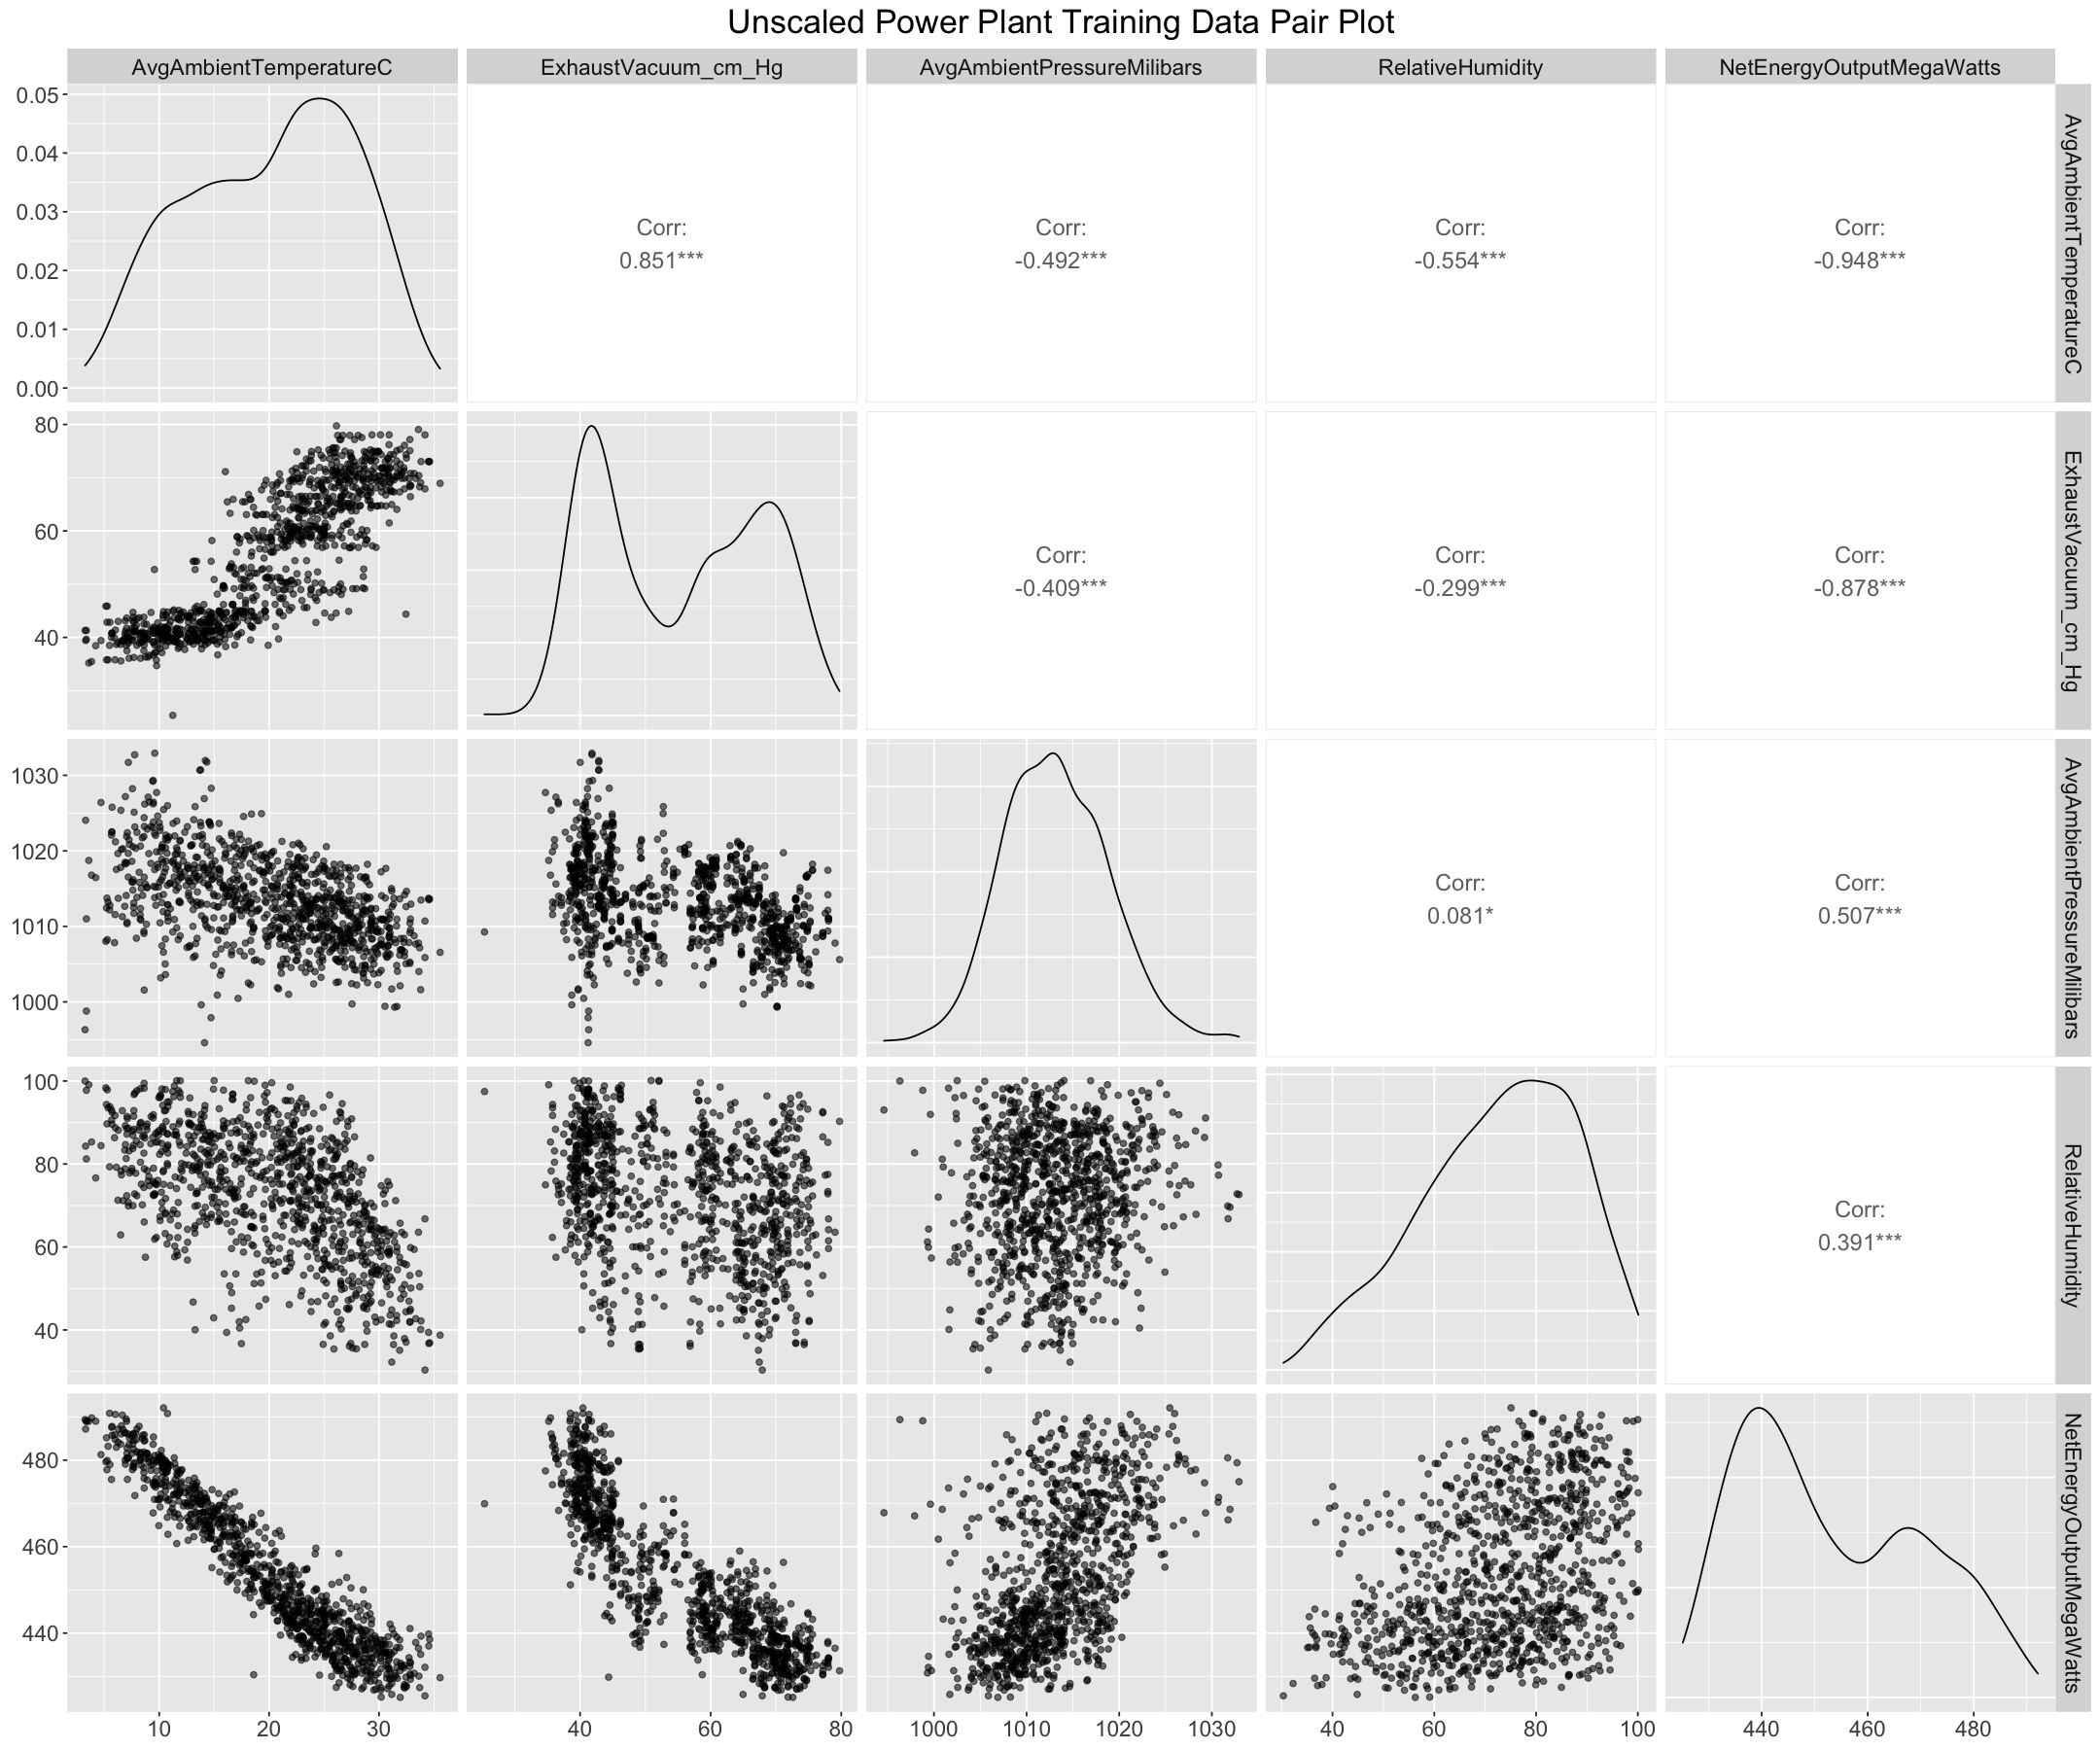

In [5]:
# set plot size options
options(repr.plot.width = 18, repr.plot.height = 15)

# subset the data for plotting (just looks like black blobs otherwise)
power_train_subset <- power_train %>% sample_frac(0.15) 

# pair plot for concrete data
ggpairs(power_train_subset,
            mapping = aes(alpha = 0.2),
            lower=list(combo=wrap("facethist", binwidth=0.5)),
            upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Unscaled Power Plant Training Data Pair Plot") +
        theme(text = element_text(size = 17),
              plot.title = element_text(hjust = 0.5))

#### Calculate Variance Inflation Factors for All Predictors

In the pair plot above, some of the predictors appear highly correlated (e.g. AvgAmbientTemperatureC vs ExhaustVacuum_cm_Hg). Below we calculate the VIF for all predictors to determine if any variables should be removed in order to stabalize parameter estimation. We will keep any variables with VIF < 5 (arbitrary cuttoff from class). 

In [6]:
predictor_names <- colnames(power_train %>% select(-NetEnergyOutputMegaWatts))
vif_all_predictors <- list()
runs <- length(predictor_names)
precision = 4

for (i in 1:runs) {
    curr_pred = predictor_names[1]
    predictor_names = predictor_names[-1] # drop the current pred so we don't calc VIF against itself (divide by zero)
    
    for (other_pred in predictor_names){
        rsq <- cor(power_train[curr_pred], 
                   power_train[other_pred],
                   method='pearson')^2
        
        vif_all_predictors[paste(curr_pred, other_pred , sep = " vs ")] = round(1 / (1 - rsq), precision)
    }
}


Although AmbientTemperatureC vs ExhaustVacuum_cm_Hg are highly correlated, the VIF suggests that it is likely not high enough to be problematic, so we will keep all predictors in model contention at this stage. 

In [7]:
vif_df <- data.frame(Variables=names(vif_all_predictors), VIF=as.double(vif_all_predictors))
vif_df


Variables,VIF
<chr>,<dbl>
AvgAmbientTemperatureC vs ExhaustVacuum_cm_Hg,3.4810
AvgAmbientTemperatureC vs AvgAmbientPressureMilibars,1.3486
AvgAmbientTemperatureC vs RelativeHumidity,1.4374
ExhaustVacuum_cm_Hg vs AvgAmbientPressureMilibars,1.2056
ExhaustVacuum_cm_Hg vs RelativeHumidity,1.1132
AvgAmbientPressureMilibars vs RelativeHumidity,1.0113


### Try forward selection of parameters? (probably won't do this)

### Cross-validation 

Generate all possible model strings (no including interactions)

TODO: Interactions

In [8]:
power_train_5fold_cv <- vfold_cv(power_train, v = 5)

In [9]:
# make model strings to test
pred_var_names <- colnames(power_train %>% select(-NetEnergyOutputMegaWatts))
num_predictors <-length(pred_var_names)
model_strings_no_interaction = c()

# selected predictor variables
selected <- c()
for (i in 1:num_predictors) {
    for (j in 1:length(pred_var_names)){
        # make a string representing the model
        curr_model_preds <- c(selected, pred_var_names[[j]])
        model_string <- paste("NetEnergyOutputMegaWatts", "~", paste(curr_model_preds, collapse="+"))
        model_strings_no_interaction <- append(model_strings_no_interaction, model_string)
    }
    selected <- c(selected, pred_var_names[[1]])
    pred_var_names <- pred_var_names[-1]
}

#### The list below is all the models that will be tested in cross-validation workflow

In [10]:
print(model_strings_no_interaction)

 [1] "NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC"                                                                
 [2] "NetEnergyOutputMegaWatts ~ ExhaustVacuum_cm_Hg"                                                                   
 [3] "NetEnergyOutputMegaWatts ~ AvgAmbientPressureMilibars"                                                            
 [4] "NetEnergyOutputMegaWatts ~ RelativeHumidity"                                                                      
 [5] "NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+ExhaustVacuum_cm_Hg"                                            
 [6] "NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+AvgAmbientPressureMilibars"                                     
 [7] "NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+RelativeHumidity"                                               
 [8] "NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+ExhaustVacuum_cm_Hg+AvgAmbientPressureMilibars"                 
 [9] "NetEnergyOutputMegaWatts ~

#### Next we run 5 fold cross-validation for each of the above models, recording the mean RMSE on the validation sets.

In [11]:
# run the cross-validation and record the results
fold_names <- unique(power_train_5fold_cv$id)
predictor_vars <- colnames(power_train %>% select(-NetEnergyOutputMegaWatts))

num_predictors <-length(predictor_vars)
runs <- length(fold_names) * 10

cv_results <- tibble(model_string = character(), val_rmse = numeric())

# extract test and train data into separate columns in the fold_cv tibble
power_train_5fold_cv <- power_train_5fold_cv %>% 
  mutate(
    train = map(splits, ~training(.x)), 
    validate = map(splits, ~testing(.x))
  )


for (model_string in model_strings_no_interaction) {
    
    # generate the models for all cross-val splits
    evaluated_models <- power_train_5fold_cv %>%
        mutate(model = map(train, ~lm(formula = as.formula(model_string), data = .x))) %>% 
    
    # map the real response validation set response and predicted response to validate_actual & validate_predicted
        mutate(validate_actual = map(validate, ~.x$NetEnergyOutputMegaWatts),
               validate_predicted = map2(model, validate, ~predict(.x, .y))) %>% 
    
    # calculate the RMSE between the real and predicted on the validation set    
        mutate(validate_rmse = map2_dbl(validate_actual, validate_predicted,
               ~rmse(actual = .x, predicted = .y)))                              
    
    
    
    cv_results <- cv_results %>% add_row(model_string = model_string, val_rmse = mean(evaluated_models$validate_rmse))
   
        
}

cv_results %>% arrange(val_rmse)


model_string,val_rmse
<chr>,<dbl>
NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+ExhaustVacuum_cm_Hg+AvgAmbientPressureMilibars+RelativeHumidity,4.539478
NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+ExhaustVacuum_cm_Hg+RelativeHumidity,4.548293
NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+RelativeHumidity,4.779221
NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+ExhaustVacuum_cm_Hg+AvgAmbientPressureMilibars,4.874054
NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+ExhaustVacuum_cm_Hg,4.937977
NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+AvgAmbientPressureMilibars,5.367306
NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC,5.414960
NetEnergyOutputMegaWatts ~ ExhaustVacuum_cm_Hg,8.382168
NetEnergyOutputMegaWatts ~ AvgAmbientPressureMilibars,14.548903


In [12]:
# TODO: residual plots, qqplots, etc.
best_model <- lm(NetEnergyOutputMegaWatts ~ ., data=power_train)

test_prediction <- predict(best_model, power_test)

results <- data.frame(pred=test_prediction, actual=power_test$NetEnergyOutputMegaWatts)

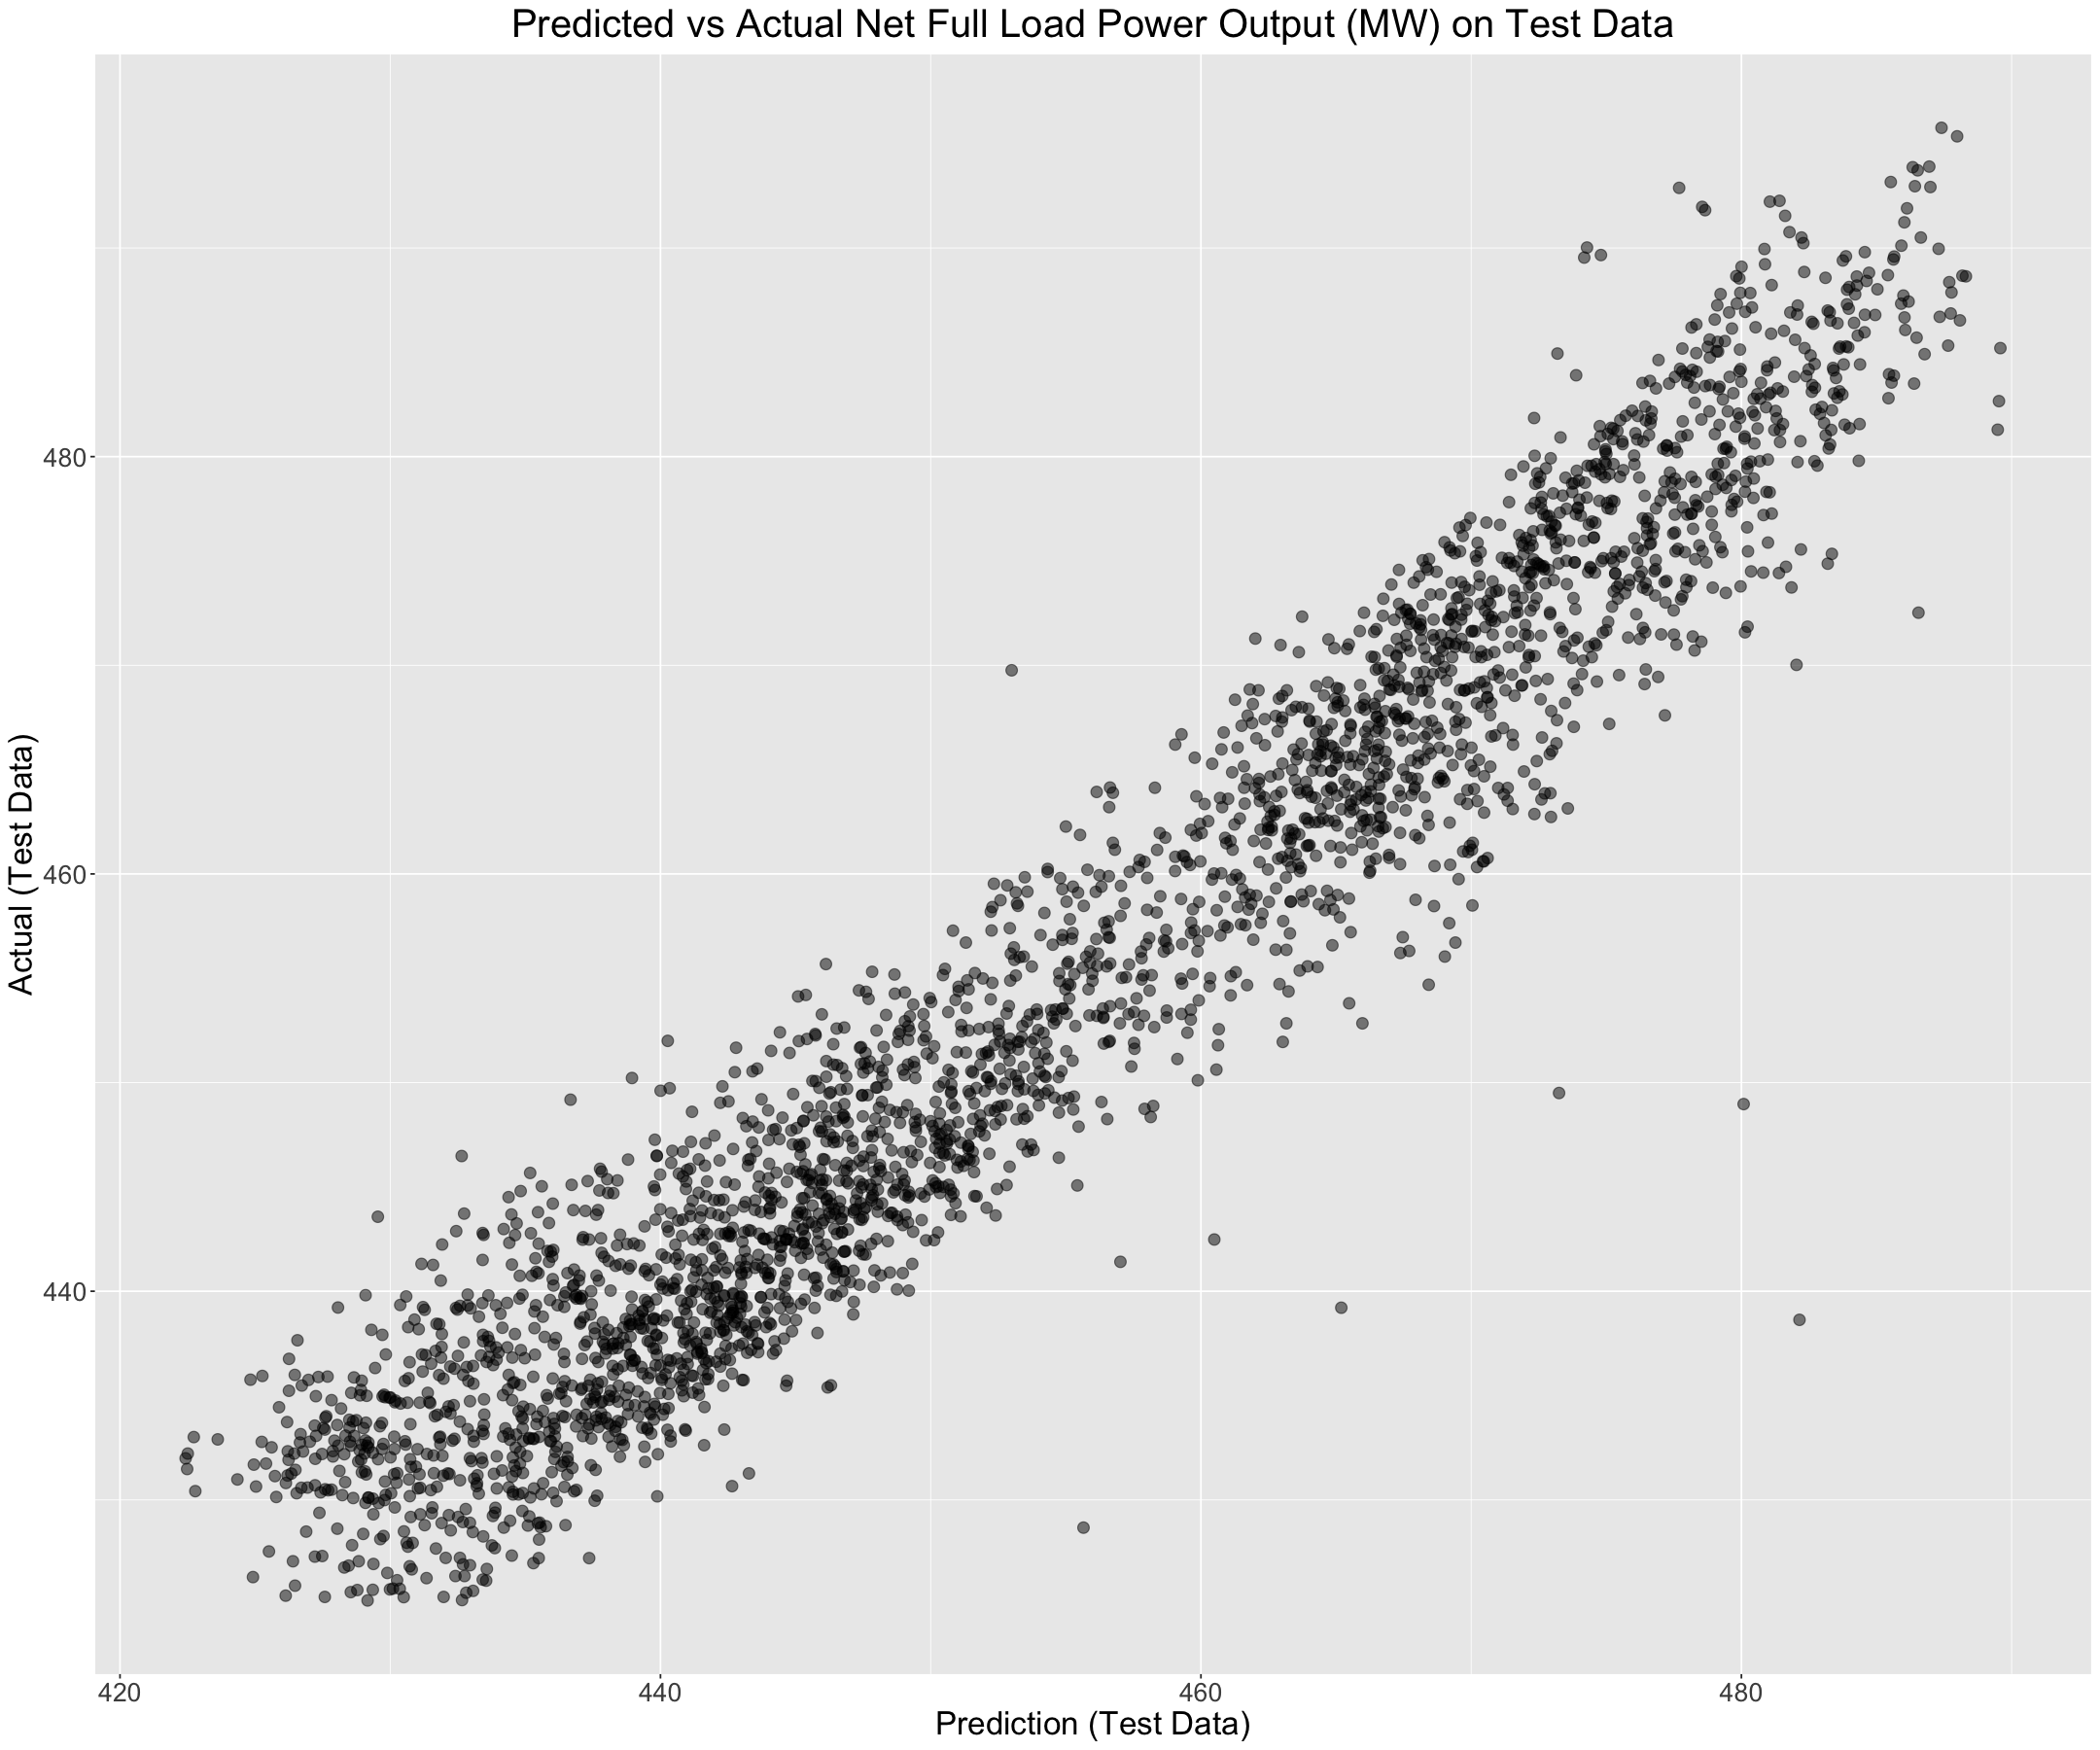

In [13]:
prediction_plot <- results %>% ggplot(aes(x=pred, y=actual)) +
                        geom_point(size=3, alpha=0.5) + 
                        labs(x = "Prediction (Test Data)", y = "Actual (Test Data)") + 
                        ggtitle("Predicted vs Actual Net Full Load Power Output (MW) on Test Data") +
                                theme(text = element_text(size=20),
                                      plot.title = element_text(hjust = 0.5))
prediction_plot